# ⌚️ DM&ML 2020 - Team Rolex

## 🖋 Authors
- Francis Ruckstuhl, 16-821-738
- Hanna Birbaum, 16-050-114
- Loïc Rouiller-Monay, 16-832-453

## 🕵️ Project description

Real or Not? NLP with Disaster Tweets: Machine Learning model that can predict which tweets are about a real disaster and which are not. The project topic is based around a Kaggle competition.


## 📝 Commits

### Best commit:

**Commit 1 : 0.808%**
- spacy_tokenizer: remove stopwords, punctuation, numbers then lemmatize and lowercase
- TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), tokenizer=spacy_tokenizer)
- LogisticRegression(solver='lbfgs', max_iter=1000)

### [B.] Previous commits

**Commit 1 : 0.808%**
- spacy_tokenizer: remove stopwords, punctuation, numbers then lemmatize and lowercase
- TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), tokenizer=spacy_tokenizer)
- LogisticRegression(solver='lbfgs', max_iter=1000)

### [C.] Progression of accuracies

<AxesSubplot:xlabel='commit_number', ylabel='accuracy'>

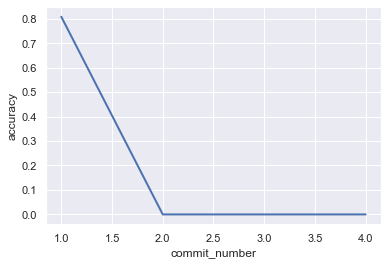

In [45]:
# /!\ You have to run Chapter 1. "libraries“ first before being able to plot the progression of accuracies
accuracy_progression = pd.read_csv('../documents/accuracy_progression.csv', sep=';')
sns.lineplot(x=accuracy_progression.commit_number, y=accuracy_progression.accuracy, linewidth=2)

# 📚 1. Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")
import spacy
# load English language model of spacy
sp = spacy.load('en_core_web_sm')
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

ModuleNotFoundError: No module named 'matplotlib'

# 📂 2. Download data


## Files
- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - a sample submission file in the correct format

In [3]:
train = pd.read_csv('../data/training_data.csv')
test = pd.read_csv('../data/test_data.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

In [4]:
train.head(5)

id    keyword               location  \
0   3738  destroyed                    USA   
1    853  bioterror                    NaN   
2  10540  windstorm  Palm Beach County, FL   
3   5988  hazardous                    USA   
4   6328    hostage             Australia    

                                                text  target  
0  Black Eye 9: A space battle occurred at Star O...       0  
1  #world FedEx no longer to transport bioterror ...       0  
2  Reality Training: Train falls off elevated tra...       1  
3  #Taiwan Grace: expect that large rocks trees m...       1  
4  New ISIS Video: ISIS Threatens to Behead Croat...       1

## Features
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6471 entries, 0 to 6470
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        6471 non-null   int64 
 1   keyword   6416 non-null   object
 2   location  4330 non-null   object
 3   text      6471 non-null   object
 4   target    6471 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 252.9+ KB


# 🔬 3. Exploratory Data Analysis

## [A.] What is the baserate of the problem?

In [42]:
base_rate = train.target.value_counts().max()/len(train)
print(f'\nThe base rate is {base_rate}')


The base rate is 0.5719363313243703


## Target class distribution

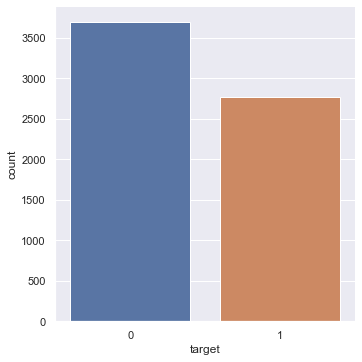

In [84]:
sns.catplot(x="target", kind="count", data=train);

## Missing values

In [85]:
train.isnull().any()

id             False
keyword         True
location        True
text           False
target         False
text_length    False
num_char       False
num_words      False
dtype: bool

It misses value in two features : keyword and location.

### Missing value in "keyword"

In [90]:
train.keyword.isnull().value_counts()

False    6416
True       55
Name: keyword, dtype: int64

### Missing value in "location"

In [91]:
train.location.isnull().value_counts()

False    4330
True     2141
Name: location, dtype: int64

## Tweets length

### Number of characters

In [63]:
train["num_char"] = train["text"].apply(len)

<AxesSubplot:xlabel='target', ylabel='num_char'>

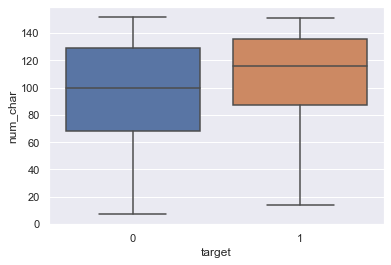

In [75]:
sns.boxplot(x='target', y='num_char', data=train)

##### Findings
Tweets about real disaster seems to be lengthier.

### Number of words

In [73]:
train["num_words"] = train["text"].apply(lambda x: len(x.split()))

<AxesSubplot:xlabel='target', ylabel='num_words'>

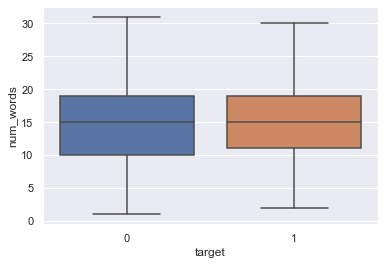

In [76]:
sns.boxplot(x='target', y='num_words', data=train)

##### Findings
Tweets about real disaster do not seem to have more words. Maybe it'll help to take this into consideration.

### Average word length

In [93]:
train["avg_word_length"] = train['text'].apply(lambda x: np.sum([len(w) for w in x.split()]) / len(x.split()))

<AxesSubplot:xlabel='target', ylabel='avg_word_length'>

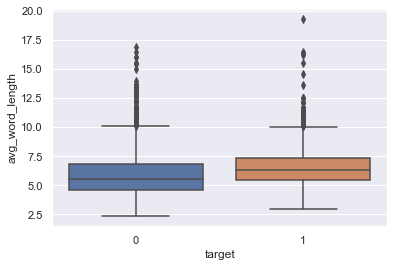

In [95]:
sns.boxplot(x='target', y='avg_word_length', data=train)

##### Findings
Tweets about real disaster seems to have lengtier average word length

### Locate disasters

In [10]:
# Where do most disasters occur / where do disaster tweets come from? 
# Potential problem to take care of: USA and United States are separate; Different US States are also separate;
train.loc[train["target"] == 1, ["location"]].value_counts()

location               
USA                        58
United States              25
Nigeria                    18
India                      18
Mumbai                     17
                           ..
Portage, IN / Worldwide     1
Porthcawl                   1
Portland, OR                1
Portland, Ore.              1
  News                      1
Length: 1323, dtype: int64

# 🧹 4. Data cleaning

In [7]:
# remove '%20' from keyword feature
train.keyword = train.keyword.apply(lambda x: str(x).replace('%20', ' '))
test.keyword = train.keyword.apply(lambda x: str(x).replace('%20', ' '))

In [8]:
# check if NaN values in the keyword feature
print(train.keyword.isnull().any())
print(test.keyword.isnull().any())

False
False


In [9]:
# use pycountry in order to check if a country appears in the location
# if yes takes the country, else turn it to NaN
# with train and test data set

In [10]:
train.location.apply(lambda x: print(x))

USA
nan
Palm Beach County, FL
USA
Australia 
Scotland
New York City
Multinational *****
Los Angeles
nan
Ad Majorem Dei Glorium
UK
GCC
New Hampshire
nan
nan
Phoenix
Oklahoma City
USA
Cumming, GA
nan
nan
Minority Privilege, USA
Brisbane Australia
nan
nan
Boston, MA
Cambridge, MA
nan
nan
Laredo, TX
Florida
Port Orange, FL
Jupiter
New York
Holly Springs, NC 
Wherever I'm needed
nan
New York City ,NY
nan
nan
nan
nan
Copenhagen, Capital Region of Denmark
United Kingdom
ilford
nan
Chippenham/Bath, UK
UK & Ibiza
San Diego California 92101
Dundee, UK
Wiltshire
Reading UK
nan
Earth 0
New York
India
Oklahoma City, OK
New York 
Shelby County
 Road to the Billionaires Club
nan
Chicago, IL 60607
1313 W.Patrick St, Frederick
nan
Leesburg, FL
Spain - China - Latin America.
Epic City, BB.
Jackson
Far Away From Home
Absecon, NJ
nan
Seattle
nan
United States
nan
nan
Memphis, TN
nan
Boise, Idaho
Alexandria, VA
State College, Pa
?????? ??? ?????? ????????
State College, PA
UK
canberra
Varanasi
Haysville, K

nan
USA
Oregon
nan
nan
Virginia, USA
London
nan
Derbyshire, United Kingdom
Broomfield, CO
nan
I-75 in Florida
Washington, D.C.
nan
Charleston, WV
nan
Yobe State
One World
Atlanta, GA
West Wales
Ylisse
nan
Flushing, Queens
In a graveyard 
nan
nan
Haarlem
nan
Zac Newsome loves me
tx
USA
Los Angeles, CA
Memphis
nan
nan
Phoenix, AZ
California
nan
nan
Los Angeles, CA
Brooklyn
nan
Daddy Kink Central
East Coast
Sydney, New South Wales
Madisonville TN
Ivano-Frankivsk
Johannesburg, South Africa
nan
nan
USA
Midwest
miami
Rock Springs, WY
Madrid, Comunidad de Madrid
Washington, DC
nan
nan
New York City, NY
nan
nan
Derby
nan
Am International
nan
nan
ss
Everywhere
nan
nan
nan
Washington, USA
ona block w/ my BOY ??
Carol Stream, Illinois
UPTOWN 
USA
nan
nan
Former Yugoslav Republic of Macedonia
Storybrooke / The Moors
Everett, WA
UK,singer,songwriter,?2 act
nan
St. Catharines, Ontario
United States
Houma La
nan
nan
36 & 38
nan
USA
nan
London/Lagos/FL ÌÏT: 6.6200132,
Tennessee, USA
TechFish 
nan
nan


New York
nan
nan
nan
ARGENTINA
Thailand Malaysia Indonesia 
Hartford, Connecticut
Nigeria 
D.C. - Baltimore - Annapolis
Pacific Northwest
don't buy the s*n
lagos nigeria
nan
Rogersville, MO
Trinidad and Tobago
Austin
sri lanka
Dublin City, Ireland
nj
nan
English Midlands
Tema,Accra
??????
Texas, USA
United States
Pakistan, Islamabad
St. Louis, MO
Pekanbaruå¡Batam Islandå¡Medan
Seattle
Canadian bread
Weyburn
nan
eBooks, North America
BOSTON-LONDON
nan
tx
New Jersey/New York
nan
nan
nan
Eldoret, kenya
Canada
[ Blonde Bi Fry. ]
nan
Huntsville, AL
nan
nan
New York
Winnipeg, MB, Canada
Madison, WI & St. Louis MO
Eagle Pass, Texas
nan
nan
nan
nan
nan
New York
nan
Bakersfield, California
Land of Lincoln
nan
nan
nan
nan
rio de janeiro | brazil
Hudson Valley, NY
Washington DC / Nantes, France
miami x dallas 
New Jersey
Surulere Lagos,Home Of Swagg
Montgomery County, MD
nan
nan
nan
Wilmington, NC
Everywhere
Philadelphia, PA 
nan
Meereen 
Gotham City
Chicago
Orbost, Victoria, Australia
Score Team

nan
Gotham City
y(our) boyfriends legs 
Huntsville, AL
Earth
ss
Calgary
nan
Home of the Takers.
South 37
Karachi, Pakistan
Akure city in ondo state 
County Durham, United Kingdom
Largo, MD
nan
nan
#GDJB #ASOT
Mooseknuckle, Maine
Philadelphia
Arthas US
Las Cruces, NM
canada
nan
nan
nan
On the court 
Spare 'Oom
USA
Bakersfield, CA
Sacramento, CA
Michigan, USA
in the Word of God
??? ??? ????? ??? ???.
nan
WESTSIDE OF PHILLY 7? BLOCK??
USA
Spying on your thoughts
with Doflamingo
nan
nan
nan
Vail Valley
nan
nan
hyderabad
South Africa
Marysville, MI
Malaysia/Jordan
Niagara Falls, Ontario
Dorset, United Kingdom
in the Word of God
On a beach 
NYC
Bend, Oregon
nan
Based out of Portland, Oregon
USA
Somalia
Manchester, NH
nan
All around the world!
toronto Û¢ dallas
Malaysia
Middle Earth / Asgard / Berk
nan
LYNBROOK
nan
nan
Mountains
 Miami Beach
nan
nan
Petaluma, CA
New York
nan
Barbados
nan
California
Jersey City, NJ
Massachusetts 
nan
nan
kano
Chicago, but Philly is home
Bushkill pa
United Sta

0       None
1       None
2       None
3       None
4       None
        ... 
6466    None
6467    None
6468    None
6469    None
6470    None
Name: location, Length: 6471, dtype: object

In [11]:
train.location.isnull().value_counts()

False    4330
True     2141
Name: location, dtype: int64

In [12]:
# no NaN in text feature
train.text.isnull().any()

False

In [13]:
# todo: régler les problèmes d'encodage: Ûª, Û_, Ûª, &amp, ;#number_of_any_length;
# création d'une expression regulière; could be helpful to remove these:
regex = re.compile(r"(Ûª|Û_|Ûª|&amp|(\d+)|((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*))")

# enlever les liens, juste les hashtags, lowercase, ponctuation
# en option voir si enlever les "@ + les pseudos" ça aide

In [14]:
train.text.apply(lambda x: print(x))

Black Eye 9: A space battle occurred at Star O784 involving 3 fleets totaling 3945 ships with 17 destroyed
#world FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps  http://t.co/5zDbTktwW7
Reality Training: Train falls off elevated tracks during windstorm http://t.co/JIOMnrCygT #Paramedic #EMS
#Taiwan Grace: expect that large rocks trees mud unstable and/or saturated land may slide ..very hazardous in hilly/mountain areas...
New ISIS Video: ISIS Threatens to Behead Croatian Hostage Within 48 Hours - TLVFaces - TLVFaces#auspol http://t.co/a6PPEgeLOX
FreeBesieged: .MartinMJ22 YouGov Which '#Tory landslide' ... you can't POSSIBLY mean the wafer-thin majority of #GÛ_ http://t.co/2q3fuEReY5
Billionaires have a plan to free half a billion dollars trapped in Venezuela for two years @BlakeSchmidt reports.

http://t.co/gbqTc7Sp9C
@JamesMelville Some old testimony of weapons used to promote conflicts
Tactics - corruption &amp; infiltration of groups
https://t.co/cyU8zxw

I Hate To Talking Otp With My Grandma... I Mean I Love Her As To Death But She Talk So Damn Much Ssshhheeesshh!!! ??????
Talk on GOZ is fantastic. Most interesting fact so far is that they manually bought all the .ru domains to sinkhole rather than seek co-op.
Friday supposed to be a happy day but it's a bloody friday hah zzzz
Reddit updates content policy promises to quarantine Û÷extremely offensiveÛª communities http://t.co/KmTwA3n1Gf
Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife #islam
FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/HQsU8LWltH via @usatoday
Have you ever remembered an old song something you haven't heared for years?  words that carry floods of memories all along. #priceless
What's up man?
Sure the #Megaquake story brought a sense of panic but the question is: will anything really change? http://t.co/9f3rDN9N3D
@JagexHelpDibi update JAG enabled but a hijacker has access m

A Rocket To The Moon  ? Sleeping With Sirens ?A Rocket To The Moon ????????????
Picking up a man in a bar is like a snowstorm you never know when he's coming how many inches you'll get or how long'll he'll stay.
If time heals all wounds how come the belly button stays the same?
A country Chim can survive!
VIDEO: 'We're picking up bodies from water' - Rescuers are searching for hundreds of migrants in the Mediterranean... http://t.co/yhQU5UV6Ok
But if it's the apocalypse lol gf m8
@NWSPocatello BG-16: So far brunt of storm just to our north. Grayed out w/ dust &amp; rain to N blue sky interspersed w/ clouds to S.
.
.@Colts get demolished by #Patriots like 500-7 and whine to @nfl about 'integrity' #CantMakeItUp #PatriotsNation http://t.co/tpW5gPmhQ4
#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_
Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...
Fire hazard asso

We're #hiring! Read about our latest #job opening here: RN Nurse Shift Manager Emergency Services - Full time... - http://t.co/sNuBZA6KSC
Agreed there - especially on automatic weapons. There's no legitimate reason for needing one @Argus_99 @HeidiA1438
@supernovalester I feel so bad for them. I can literally feel that feeling of your heart sinking bc you didn't get anyone ugh jfc
@RohnertParkDPS You're on stage now! Right under the lights! Isn't it funny?! Where do you get the goofballs with which you staff your PD?
RCMP confirm fatalities in two-vehicle crash: TCH remains closed at Whitbourne due to accident http://t.co/0RokDuTyUN
California LawÛÓNegligence and Fireworks Explosion Incidents http://t.co/d5w2zynP7b
@TeamHendrick @TeamHendrick @RIRInsider Fingers crossed that there will be a driver from Hendricks in Military Hospitality w/ @neanea2724!
'California: Spring Oil Spill Estimate Grows ' by THE ASSOCIATED PRESS via NYT http://t.co/zdpa4DBtsU
The sky's clear the storm has pass

0       None
1       None
2       None
3       None
4       None
        ... 
6466    None
6467    None
6468    None
6469    None
6470    None
Name: text, Length: 6471, dtype: object

In [15]:
# to do

In [16]:
train.keyword.value_counts()

nan                    55
deluge                 39
earthquake             38
harm                   37
collision              37
                       ..
forest fire            18
epicentre              10
threat                 10
radiation emergency     9
inundation              6
Name: keyword, Length: 222, dtype: int64

In [17]:
train.keyword.unique()

array(['destroyed', 'bioterror', 'windstorm', 'hazardous', 'hostage',
       'landslide', 'trapped', 'weapons', 'burning buildings', 'thunder',
       'refugees', 'panicking', 'suicide bombing', 'buildings on fire',
       'seismic', 'bridge collapse', 'emergency', 'body bags', 'wounded',
       'quarantined', 'violent storm', 'blight', 'destroy', 'detonation',
       'ambulance', 'armageddon', 'military', 'fatal', 'stretcher',
       'devastated', 'thunderstorm', 'hurricane', 'mudslide',
       'fatalities', 'razed', 'ruin', 'hostages', 'bioterrorism',
       'cyclone', 'hazard', 'nan', 'fear', 'fire truck', 'terrorism',
       'wreckage', 'fatality', 'forest fire', 'derail', 'fire',
       'derailment', 'obliterated', 'devastation', 'lightning', 'rubble',
       'casualties', 'screams', 'riot', 'wreck', 'bombing', 'wild fires',
       'nuclear disaster', 'army', 'crash', 'forest fires', 'disaster',
       'storm', 'hellfire', 'engulfed', 'blood', 'mass murderer',
       'terrorist', 

In [18]:
train

id            keyword               location  \
0      3738          destroyed                    USA   
1       853          bioterror                    NaN   
2     10540          windstorm  Palm Beach County, FL   
3      5988          hazardous                    USA   
4      6328            hostage             Australia    
...     ...                ...                    ...   
6466   4377         earthquake              ARGENTINA   
6467   3408             derail                    NaN   
6468   9794            trapped                    NaN   
6469  10344            weapons         Beirut/Toronto   
6470   1779  buildings on fire                    NaN   

                                                   text  target  
0     Black Eye 9: A space battle occurred at Star O...       0  
1     #world FedEx no longer to transport bioterror ...       0  
2     Reality Training: Train falls off elevated tra...       1  
3     #Taiwan Grace: expect that large rocks trees m...       1  
4     New ISIS Video: ISIS Threatens to Behead Croat...       1  
...                                                 ...     ...  
6466  #Earthquake #Sismo M 1.9 - 15km E of Anchorage...       1  
6467  @EmiiliexIrwin Totally agree.She is 23 and kno...       0  
6468  Hollywood Movie About Trapped Miners Released ...       1  
6469  Friendly reminder that the only country to eve...       1  
6470  Buildings are on fire and they have time for a...       1  

[6471 rows x 5 columns]

# 🛠 [D.] 5. Feature Engineering

In [68]:
# add number of characters and number of words in it

# ⚙️ 6. Preprocessing

In [19]:
# Create tokenizer function for preprocessing
def spacy_tokenizer(text):

    # Define stopwords, punctuation, and numbers
    stop_words = spacy.lang.en.stop_words.STOP_WORDS
    punctuations = string.punctuation
    # numbers = "0123456789"

    # Create spacy object
    mytokens = sp(text)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]


    # Return preprocessed list of tokens
    return mytokens

In [20]:
# Tokenize texts
processed_texts = []
for text in train.text:
    processed_text = spacy_tokenizer(text)
    processed_texts.append(processed_text)

In [21]:
processed_texts

[['black',
  'eye',
  '9',
  'space',
  'battle',
  'occur',
  'star',
  'o784',
  'involve',
  '3',
  'fleet',
  'total',
  '3945',
  'ship',
  '17',
  'destroy'],
 ['world',
  'fedex',
  'longer',
  'transport',
  'bioterror',
  'germ',
  'wake',
  'anthrax',
  'lab',
  'mishap',
  'http://t.co/5zdbtktww7'],
 ['reality',
  'training',
  'train',
  'fall',
  'elevated',
  'track',
  'windstorm',
  'http://t.co/jiomnrcygt',
  'paramedic',
  'ems'],
 ['taiwan',
  'grace',
  'expect',
  'large',
  'rock',
  'tree',
  'mud',
  'unstable',
  'and/or',
  'saturate',
  'land',
  'slide',
  '..',
  'hazardous',
  'hilly',
  'mountain',
  'area',
  '...'],
 ['new',
  'isis',
  'video',
  'isis',
  'threaten',
  'behead',
  'croatian',
  'hostage',
  '48',
  'hour',
  'tlvface',
  'tlvfaces#auspol',
  'http://t.co/a6ppegelox'],
 ['freebesieged',
  '.martinmj22',
  'yougov',
  'tory',
  'landslide',
  '...',
  'possibly',
  'mean',
  'wafer',
  'thin',
  'majority',
  'g\x89û',
  'http://t.co/2q

# 🤖 7. Models

## 7.1 Logistic Regression

In [23]:
# Import packages
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

In [24]:
# Select features
X = train['text'] # the features we want to analyze
y = train['target'] # the labels, or answers, we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

X_train

6214    Take this China get demolished and sent back t...
5845    Explosion in Gaza Strip kills four wounds 30; ...
4250    Rolling sandunes the gentle lapping of the sea...
6154    @freefromwolves GodsLove &amp; #thankU brother...
6110    Wreckage 'Conclusively Confirmed' as From MH37...
                              ...                        
664     @wwexdreamer talk to please don't harm your se...
3276    'I did another one I did another one. You stil...
1318    Watch This Airport Get Swallowed Up By A Sands...
723     Cuban leader extends sympathy to Vietnam over ...
2863    @20skyhawkmm20 @traplord_29 @FREDOSANTANA300 @...
Name: text, Length: 5176, dtype: object

In [25]:
%%time
# Define vectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), tokenizer=spacy_tokenizer)

# Define classifier
classifier = LogisticRegression(solver='lbfgs', max_iter=1000)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

Wall time: 58.8 s


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(encoding='latin-1', min_df=5,
                                 ngram_range=(1, 2), sublinear_tf=True,
                                 tokenizer=<function spacy_tokenizer at 0x000001A08775D040>)),
                ('classifier', LogisticRegression(max_iter=1000))])

In [26]:
# Predictions
y_pred = pipe.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7784


## 7.2 Doc2Vec

In [27]:
#to do

# 🏆 8. Submission

In [28]:
# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])

In [29]:
pipe.fit(train.text, train.target)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(encoding='latin-1', min_df=5,
                                 ngram_range=(1, 2), sublinear_tf=True,
                                 tokenizer=<function spacy_tokenizer at 0x000001A08775D040>)),
                ('classifier', LogisticRegression(max_iter=1000))])

In [30]:
preds = pipe.predict(test.text)

In [31]:
preds

array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

In [32]:
sample_submission.target = preds

In [33]:
sample_submission

target
0          0
1          0
2          1
3          0
4          0
...      ...
1137       1
1138       1
1139       1
1140       0
1141       1

[1142 rows x 1 columns]

In [35]:
sample_submission.to_csv('submission-001.csv', index=False)